In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
import pandas as pd
import torchvision
from torch.autograd import Variable

In [2]:
path_to_data = '/Users/janbraunsdorff/Studienarbeit-projekt/data'
path_to_validation_annotation = path_to_data + "/validation.csv"
path_to_training_annotation = path_to_data + "/training.csv"
path_to_validatoin_data = path_to_data + '/boneage-validation-dataset/'
path_to_training_data = path_to_data + '/boneage-training-dataset/'
path = path_to_data + '/pickel/v3'

In [3]:
model = torch.load('model/vit.pht', map_location=torch.device('cpu'))
model.eval()
print('**done**')

Device:  cpu
**done**


In [4]:
def processImages(img_path, resize_to=500, reduce_to=380, out_to=256):
    img = cv2.imread(img_path)
    size_target = resize_to
    img = cv2.resize(img, (resize_to, resize_to), interpolation=cv2.INTER_LINEAR)

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)


    x = y = (size_target - reduce_to) // 2
    h = w = reduce_to
    img = bgr[y:y + h, x:x + w]

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    kernel = np.ones((2,2),np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

    img = cv2.resize(img, (out_to, out_to), interpolation=cv2.INTER_LINEAR)

    
    return img

def img_to_tensor(base_path):
    img = processImages(img_path=base_path)
    arr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    t_img = torch.tensor(arr)
    t_img_normalize = t_img.unsqueeze(0)

    return t_img_normalize

In [18]:
def getconding(path):
    img = img_to_tensor(path)
    img = img / 255.0
    img = (img-1)*-1
    patches = model.patches(img.unsqueeze(0).float())
    encoding = model.encode_patches(patches.float())

    for t in model.transformers:
            encoding = t(encoding)

    t = torch.mean(encoding, 2)
    t = t.view(-1, 16, 16)

    t -= t.min(1, keepdim=True)[0]
    t /= t.max(1, keepdim=True)[0]
    mask = scale_maks(t).unsqueeze(1)

    zeros = torch.zeros_like(mask)
    ones = torch.ones_like(mask)

    mask =  torch.sub(mask, 0.55)
    mask = torch.where(mask < 0, ones, zeros)
    masked_image = mask * img


    small_mask = torch.sub(t, 0.45)
    zeros = torch.zeros_like(small_mask)
    ones = torch.ones_like(small_mask)
    small_mask = torch.where(small_mask > 0, ones, zeros)

    return img, t, small_mask,  masked_image


In [19]:
def scale_maks(mask):
    t = mask.repeat_interleave(2).view(-1, 16, 32).repeat(1, 1, 2).view(-1,32,32)
    t = t.repeat_interleave(2).view(-1, 32,64).repeat(1,1,2).view(-1,64,64)
    t = t.repeat_interleave(2).view(-1, 64,128).repeat(1,1,2).view(-1,128,128)
    t = t.repeat_interleave(2).view(-1, 128,256).repeat(1,1,2).reshape(-1,256,256)
    return t

<ipython-input-20-296dacf64f9f>:27: UserWarning: set_ticks() must have been called.
  cbar.set_ticklabels([])


<Figure size 792x1080 with 0 Axes>

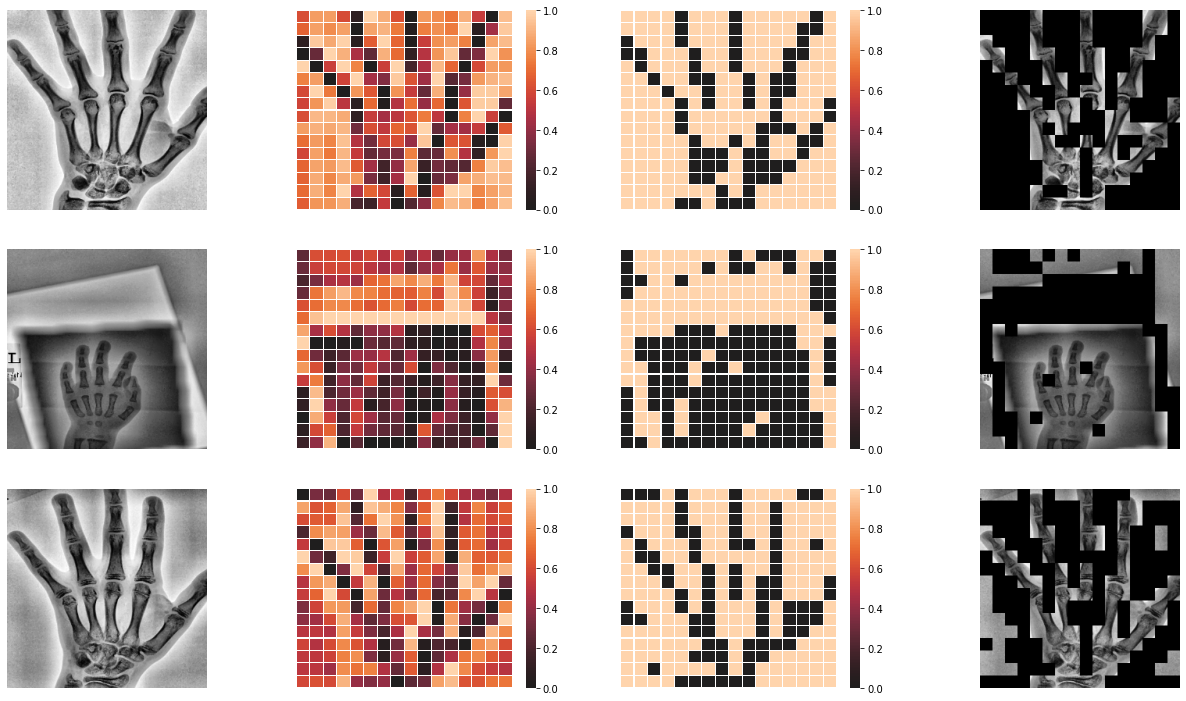

In [20]:
plt.figure(figsize=(11,15))
plt.subplots(figsize=(18,10))
plt.tight_layout()

imges = ["1377.png", "1378.png", "1400.png"]

for i in range (3):
    img, mask, reduce_maks, img_maks = getconding(path_to_training_data + imges[i])

    plt.subplot(3, 4, i*4+1)
    plt.imshow(img.permute(1,2,0).detach(), cmap='gray')
    plt.axis('off')

    plt.subplot(3, 4, i*4+2)

    ax = sns.heatmap(
        mask.squeeze().detach(),
        cbar=True,
        vmin=0, vmax=1,
        annot=False,
        xticklabels=False, 
        yticklabels=False,
        center=0,
        linewidths=.1
    )
    cbar = ax.collections[0].colorbar
    cbar.set_ticklabels([])


    plt.subplot(3, 4, i*4+3)
    ax = sns.heatmap(
        reduce_maks.squeeze().detach(),
        cbar=True,
        vmin=0, vmax=1,
        annot=False,
        xticklabels=False, 
        yticklabels=False,
        center=0,
        linewidths=.1
    )

    plt.subplot(3, 4, i*4+4)
    plt.imshow(img_maks.squeeze(), cmap='gray')
    plt.axis('off')

In [21]:
img, mask, reduce_maks, img_maks =  getconding(path_to_training_data + '1377.png')
img = img / 255.0

In [12]:
torch.max(img), torch.min(img)

(tensor(0.9882), tensor(0.0118))

In [13]:
img = (img -1)*-1

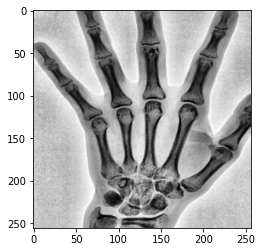

In [14]:
plt.imshow(img.permute(1,2,0).detach(), cmap='gray')